In [7]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [8]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [9]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [11]:
#Loading Data

In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [13]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


In [14]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [15]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [16]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
#x_preview, y_preview = get_three_classes(test_images, test_labels)

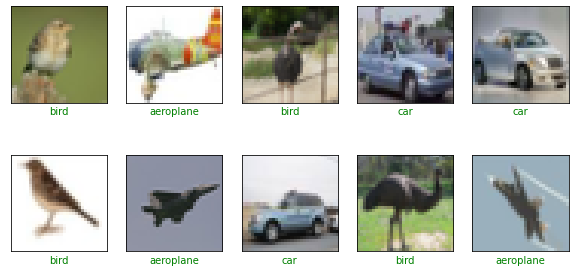

In [17]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [18]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

In [19]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [20]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [21]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

In [22]:
results = []

## Experiment 0.5: DNN with 1 layer (no regularization)

In [23]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(32,32,3)))
model.add(layers.Dense(units=384, activation=tf.nn.relu))
#model.add(layers.Dense(units=128, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 384)               1180032   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3850      
Total params: 1,183,882
Trainable params: 1,183,882
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/mnt/Assignement2/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
450/450 [==============================] - 1s 2ms/step - loss: 1.9852 - accuracy: 0.3081 - val_loss: 1.8515 - val_accuracy: 0.3286
Epoch 2/200
450/450 [==============================] - 1s 2ms/step - loss: 1.7631 - accuracy: 0.3716 - val_loss: 1.7429 - val_accuracy: 0.3680
Epoch 3/200
450/450 [==============================] - 1s 2ms/step - loss: 1.6780 - accuracy: 0.4041 - val_loss: 1.6867 - val_accuracy: 0.3878
Epoch 4/200
450/450 [==============================] - 1s 2ms/step - loss: 1.6319 - accuracy: 0.4192 - val_loss: 1.6670 - val_accuracy: 0.4014
Epoch 5/200
450/450 [==============================] - 1s 2ms/step - loss: 1.5953 - accuracy: 0.4335 - val_loss: 1.6536 - val_accuracy: 0.4138
Epoch 6/200
450/450 [==============================] - 1s 2ms/step - loss: 1.5616 - accuracy: 0.4457 - val_loss: 1.6122 - val_accuracy: 0.4306
Epoch 7/200
450/450 [==============================] - 1s 2ms/step - loss: 1.5381 - accuracy: 0.4546 - val_loss: 1.5780 - val_accuracy: 0.4274

In [27]:
history_dict = history.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)

In [28]:
train_losses = history.history["loss"]
train_accs = history.history["accuracy"]
val_losses = history.history["val_loss"]
val_accs = history.history["val_accuracy"]
epochs = len(train_losses)

In [29]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('ttest se accuracy: ', accuracy * 100, "%")


313/313 [==============================] - 1s 2ms/step - loss: 1.4766 - accuracy: 0.4767
ttest se accuracy:  47.67000079154968 %


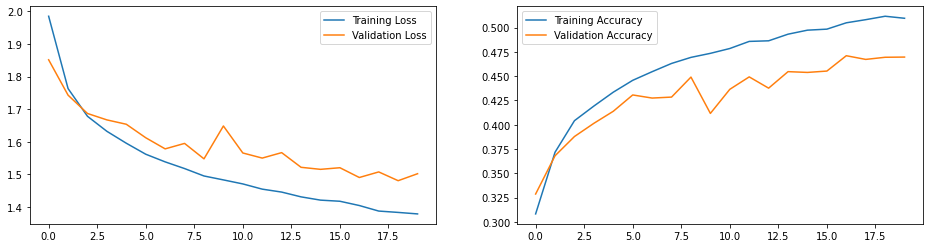

In [30]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [31]:
result_1 = {"Experiemnt": "Experiment 0.5: DNN with 1 Layer w/o reg", "Test_Accuracy": accuracy,
            "loss": loss, "Train_Accuracy":train_accs[-1], "Train_Loss":train_losses[-1],
            "Val_Accuracy":val_accs[-1],
           "Val_Loss":val_losses[-1]}
results.append(result_1)

## Experiment 1: DNN with 2 layers (no regularization)

In [32]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(32,32,3)))
model.add(layers.Dense(units=384, activation=tf.nn.relu))
model.add(layers.Dense(units=384, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 384)               1180032   
_________________________________________________________________
dense_3 (Dense)              (None, 384)               147840    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                3850      
Total params: 1,331,722
Trainable params: 1,331,722
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [35]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/mnt/Assignement2/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
450/450 [==============================] - 1s 2ms/step - loss: 1.8923 - accuracy: 0.3208 - val_loss: 1.7586 - val_accuracy: 0.3620
Epoch 2/200
450/450 [==============================] - 1s 2ms/step - loss: 1.6819 - accuracy: 0.3988 - val_loss: 1.6573 - val_accuracy: 0.4032
Epoch 3/200
450/450 [==============================] - 1s 2ms/step - loss: 1.5973 - accuracy: 0.4300 - val_loss: 1.6062 - val_accuracy: 0.4234
Epoch 4/200
450/450 [==============================] - 1s 2ms/step - loss: 1.5327 - accuracy: 0.4538 - val_loss: 1.5528 - val_accuracy: 0.4472
Epoch 5/200
450/450 [==============================] - 1s 2ms/step - loss: 1.4901 - accuracy: 0.4687 - val_loss: 1.5497 - val_accuracy: 0.4388
Epoch 6/200
450/450 [==============================] - 1s 2ms/step - loss: 1.4571 - accuracy: 0.4826 - val_loss: 1.5029 - val_accuracy: 0.4616
Epoch 7/200
450/450 [==============================] - 1s 2ms/step - loss: 1.4250 - accuracy: 0.4948 - val_loss: 1.4994 - val_accuracy: 0.4666

In [36]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100, "%")

313/313 [==============================] - 1s 2ms/step - loss: 1.4477 - accuracy: 0.4863
test set accuracy:  48.6299991607666 %


In [37]:
history_dict = history.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)

In [38]:
train_losses = history.history["loss"]
train_accs = history.history["accuracy"]
val_losses = history.history["val_loss"]
val_accs = history.history["val_accuracy"]
epochs = len(train_losses)

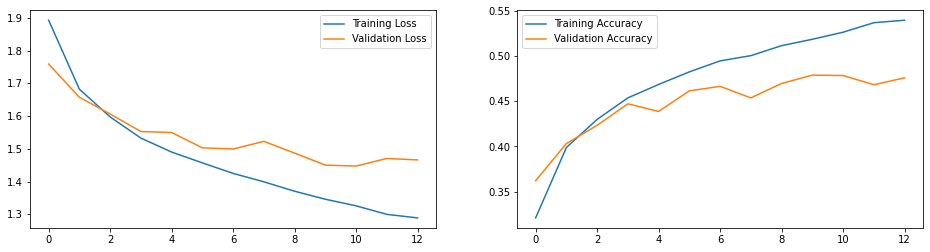

In [39]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [40]:
result_2 = {"Experiemnt": "Experiment 1: DNN with 2 Layer w/o reg", "Test_Accuracy": accuracy,
            "loss": loss, "Train_Accuracy":train_accs[-1], "Train_Loss":train_losses[-1],
            "Val_Accuracy":val_accs[-1],
            "Val_Loss":val_losses[-1]}
results.append(result_2)

## Experiment 2: DNN with 3 layers (no regularization)

In [41]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(32,32,3)))
model.add(layers.Dense(units=384, activation=tf.nn.relu))
model.add(layers.Dense(units=384, activation=tf.nn.relu))
model.add(layers.Dense(units=384, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [43]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/mnt/Assignement2/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
450/450 [==============================] - 1s 3ms/step - loss: 1.8584 - accuracy: 0.3260 - val_loss: 1.7583 - val_accuracy: 0.3644
Epoch 2/200
450/450 [==============================] - 1s 2ms/step - loss: 1.6704 - accuracy: 0.4036 - val_loss: 1.6308 - val_accuracy: 0.4190
Epoch 3/200
450/450 [==============================] - 1s 2ms/step - loss: 1.5810 - accuracy: 0.4347 - val_loss: 1.5845 - val_accuracy: 0.4302
Epoch 4/200
450/450 [==============================] - 1s 2ms/step - loss: 1.5203 - accuracy: 0.4556 - val_loss: 1.5374 - val_accuracy: 0.4470
Epoch 5/200
450/450 [==============================] - 1s 2ms/step - loss: 1.4665 - accuracy: 0.4777 - val_loss: 1.5393 - val_accuracy: 0.4368
Epoch 6/200
450/450 [==============================] - 1s 2ms/step - loss: 1.4390 - accuracy: 0.4859 - val_loss: 1.5128 - val_accuracy: 0.4530
Epoch 7/200
450/450 [==============================] - 1s 2ms/step - loss: 1.3962 - accuracy: 0.5027 - val_loss: 1.4950 - val_accuracy: 0.4694

In [44]:
history_dict = history.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)

In [45]:
train_losses = history.history["loss"]
train_accs = history.history["accuracy"]
val_losses = history.history["val_loss"]
val_accs = history.history["val_accuracy"]
epochs = len(train_losses)

In [46]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100, "%")

313/313 [==============================] - 1s 2ms/step - loss: 1.4677 - accuracy: 0.5026
test set accuracy:  50.26000142097473 %


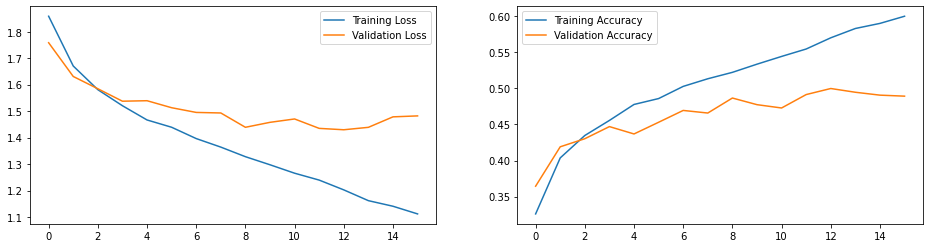

In [47]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [48]:
result_3 = {"Experiemnt": "Experiment 2: DNN with 3 Layer w/o reg", "Test_Accuracy": accuracy,
            "loss": loss, "Train_Accuracy":train_accs[-1], "Train_Loss":train_losses[-1],
            "Val_Accuracy":val_accs[-1],
           "Val_Loss":val_losses[-1]}
results.append(result_3)

In [49]:
results_df = pd.DataFrame(results)


In [50]:
results_df.to_csv("exp1&2_output.csv", index=False)

## Please see Assignment2_Woo-Experiement3-4.ipynb to continue